In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("/kaggle/input"))

['chicago_community_areas.csv']


In [3]:
# setting up BigQuery
import bq_helper
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from bq_helper import BigQueryHelper

# matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize

import os

In [5]:
chicago_crime = BigQueryHelper(active_project = "bigquery-public-data",
                                       dataset_name = "chicago_crime")

print(f"table : {chicago_crime.list_tables()}")
print(chicago_crime.head("crime"))

table : ['crime']
   unique_key              ...                                     location
0    10028966              ...                 (41.77785092, -87.772151653)
1    10125718              ...                (41.983637967, -87.739647567)
2    10144967              ...                (41.780566533, -87.783816505)
3    10158981              ...                (41.814188149, -87.632306142)
4    10164583              ...                (41.695982095, -87.596653142)

[5 rows x 22 columns]


In [6]:
#let's display the locations where these crimes occured. The coordinates have been 
query = """SELECT latitude, longitude, year
            FROM `bigquery-public-data.chicago_crime.crime`
            WHERE latitude > 37
            """
print(chicago_crime.estimate_query_size(query))
crime_loc = chicago_crime.query_to_pandas_safe(query)

query = """SELECT community_area, count(unique_key)
            FROM `bigquery-public-data.chicago_crime.crime`
            WHERE year > 2010 AND community_area IS NOT NULL AND community_area > 0 AND latitude > 37
            GROUP BY community_area
            ORDER BY  community_area
            """
print(chicago_crime.estimate_query_size(query))
crime_loc_dist = chicago_crime.query_to_pandas_safe(query)

query = """SELECT latitude, longitude, community_area
            FROM `bigquery-public-data.chicago_crime.crime`
            WHERE year > 2010 AND community_area IS NOT NULL AND community_area > 0 AND latitude > 37
            ORDER BY  latitude
            """
print(chicago_crime.estimate_query_size(query))
murd_dist = chicago_crime.query_to_pandas_safe(query)

print("finished")

0.15011369436979294
0.19631417840719223
0.1958627626299858
finished


In [7]:
pf = crime_loc.groupby('year').latitude.nunique()
pf.values

array([218825, 192457, 196871, 194794, 191395, 190860, 189427, 186752,
       179319, 175669, 168666, 162748, 149109, 138457, 131417, 132761,
       129224, 117857])

In [8]:
crime_loc_dist.head()

,community_area,f0_
0,1,32876
1,2,28642
2,3,31647
3,4,16192
4,5,12423


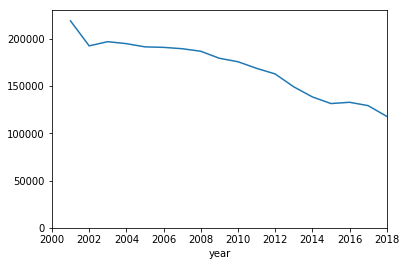

In [9]:
pf.plot(x = 'year',y = 'nr of crimes',xlim = (2000,2018),ylim = (0,230000))

**Let's plot this data geographically.**

We've excluded the single data point of the crime that occurs far outside of chicago.

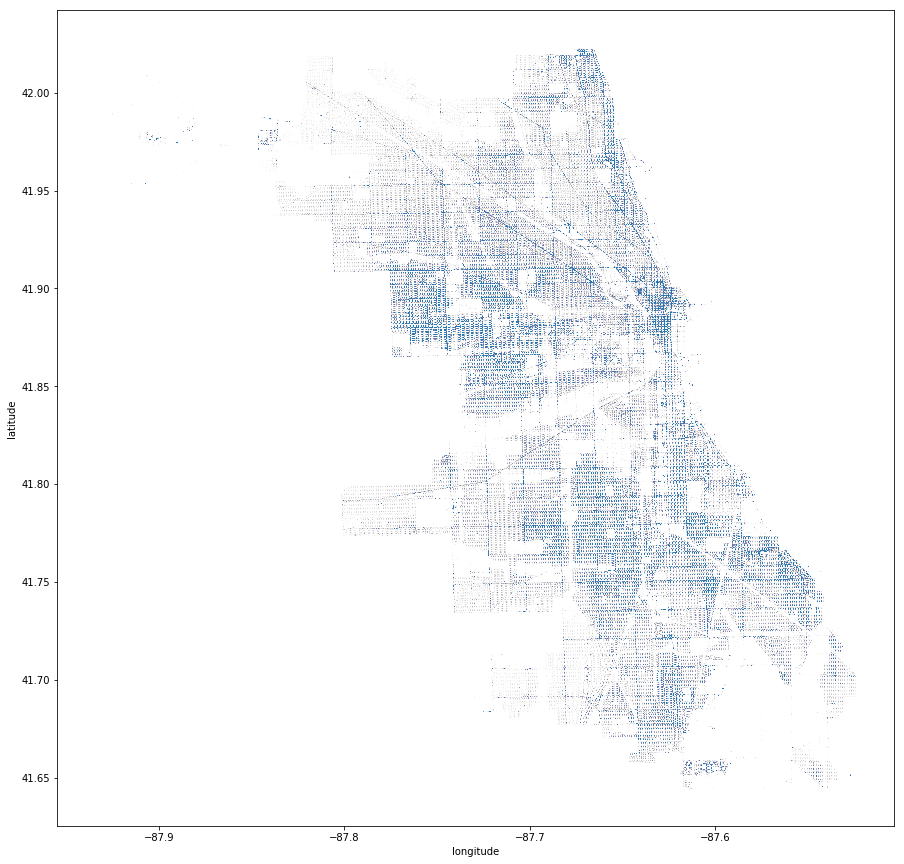

In [10]:
crime_loc.plot(kind='scatter',x = "longitude", y = "latitude",alpha = 0.0025, s = 0.1, figsize = (15,15))

Right now it's mostly a population density map. To my surprise Interstate 90 etc., and the chicago river are clearly visible by the absense of crime. While other streets like 'S. Archer Ave' and 'N Milwaukee Ave' are clearly visible.

**EXTRA DATASET**

Since I miss some essential data (to me): the population per 'community area' I went on Wikipedia to retrieve the relevant data myself. The data comes from a 2015 census. And apparently the population of Chicago didn't change much the last 5 years.

In [11]:
community_area = pd.read_csv("../input/chicago_community_areas.csv")
#community_area = pd.read_csv("../input/chicago-community-areas/chicago_community_areas.csv")
os.listdir("../input")

['chicago_community_areas.csv']

In [12]:
print(crime_loc_dist[crime_loc_dist.columns].head(5))

   community_area    f0_
0               1  32876
1               2  28642
2               3  31647
3               4  16192
4               5  12423


In [20]:
nr_of_years = crime_loc[crime_loc['year']>2010].nunique()['year']

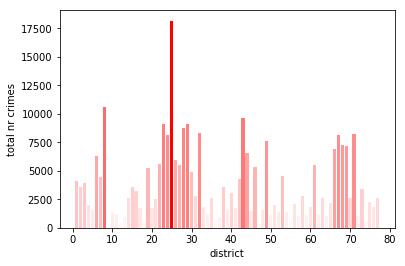

In [21]:
Y = crime_loc_dist[crime_loc_dist.columns[1]]/nr_of_years
X = crime_loc_dist[crime_loc_dist.columns[0]]
alphalist = Y/max(Y)
rgba_colors = np.zeros((len(Y),4))
# for red the first column needs to be one
rgba_colors[:,0] = 1.0
# the fourth column needs to be your alphas
rgba_colors[:, 3] = alphalist

plt.bar(X,Y,color=rgba_colors)
plt.xlabel('district')
plt.ylabel('total nr crimes')
plt.show()



Y_adjusted = []
for x in X:
    try:
        Y_adjusted.append(Y[x]/community_area['population'][x])
    except:
        Y_adjusted.append(0)
 

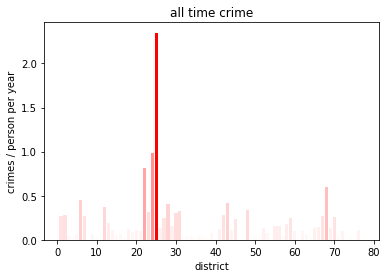

In [22]:
alphalist = Y_adjusted/max(Y_adjusted)

rgba_colors = np.zeros((len(crime_loc_dist[crime_loc_dist.columns[1]]),4))
# for red the first column needs to be one
rgba_colors[:,0] = 1.0

# the fourth column needs to be your alphas
rgba_colors[:, 3] = alphalist
plt.bar(X,Y_adjusted,color=rgba_colors)
plt.title('all time crime')
plt.xlabel('district')
plt.ylabel('crimes / person per year')
plt.show()

In [23]:
colorlist = np.zeros((len(murd_dist['community_area']),1))

i = 0
for x in murd_dist['community_area']:
    colorlist[i] = Y_adjusted[x-1]
    i += 1

In [24]:
alphalist = colorlist/max(colorlist)
alphalist = alphalist.astype('float')

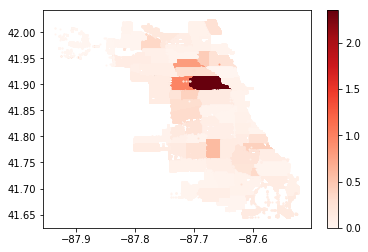

In [25]:
df = murd_dist
import matplotlib.cm as cmx

cs = Y_adjusted
cm = plt.get_cmap('Reds')
cNorm = matplotlib.colors.Normalize(vmin=min(cs), vmax=max(cs))
for district in range(77):
    X = df.loc[df['community_area']==district].iloc[:,0:2].values      
    
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
    plt.scatter(X[:,1],X[:,0],s=1, c=scalarMap.to_rgba(cs[district]))
scalarMap.set_array(cs)
    
plt.colorbar(scalarMap)
plt.show()

**Issues**
- the number of crimes is quite high: it should be X per 100,000 but now there are more crimes than there are inhabitants per year.
- the exceptionally high nr of crimes in district 24 should be investigated. Is there sampling bias? Are there some other issues with the data for that particular district?